# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

np.random.seed(2019)

- Helper Functions

In [2]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0, :], cmap=plt.cm.Spectral)

In [3]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    
    return s

In [4]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

# Overview of the Data

- Load Data

In [5]:
X, Y = load_planar_dataset()

- Overview

In [6]:
X.shape, Y.shape

((2, 400), (1, 400))

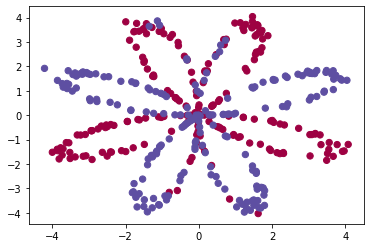

In [7]:
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral)

# Try with simple Logistic Regression

/home/denn1s/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denn1s/miniconda3/envs/ds/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy of logistic regression: 47%


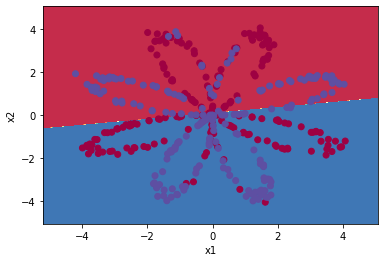

In [8]:
# Train
lr_clf = sklearn.linear_model.LogisticRegressionCV()
lr_clf.fit(X.T, Y.T)

# Predict
Y_pred_lr = lr_clf.predict(X.T)

# Print accuracy
print('Accuracy of logistic regression: %d' % float((np.dot(Y, Y_pred_lr) + np.dot(1 - Y, 1 - Y_pred_lr)) / float(Y.size) * 100)
     + '%')

# Plot decision boundary
plot_decision_boundary(lambda x: lr_clf.predict(x), X, Y)

# Neural Network Model

## All parts

1. Initialize Parameters

In [9]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    params = {'W1': W1,
              'b1': b1,
              'W2': W2,
              'b2': b2}
    
    return params

2. Forward Propogation

In [10]:
def forward_propogation(X, params):
    # Retrieve parameters
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    # Implement forward propogation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    # Assertion
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {'Z1': Z1,
             'A1': A1,
             'Z2': Z2,
             'A2': A2}
    
    return A2, cache

3. Compute Cost Function

In [11]:
def compute_cost(A2, Y, params):
    # Size of training instances
    m = Y.shape[1]
    
    # Compute Cross-Entropy Cost
    logprobs = Y * np.log(A2) + (1 - Y) * np.log(1 - A2)
    cost = - 1. / m * np.sum(logprobs)
    
    # Assertion
    assert(isinstance(cost, float))
    
    return cost

4. Backward Propogation

In [12]:
def backward_propogation(params, cache, X, Y):
    # Size of training instances
    m = X.shape[1]
    
    # Retrieve parameters
    W1 = params['W1']
    W2 = params['W2']
    
    # Retreive cache variables
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Implement backward propogation
    dZ2 = A2 - Y
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - np.power(A1, 2)))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

5. Gradient Descent Update

In [13]:
def GD_update(params, grads, lr=1.2):
    # Retrieve parameters
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    # Retrieve gradients
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}
    
    return params

## Model

In [14]:
def nn_model(X, Y, n_h, epochs=10000, print_cost=False):
    # initialization
    np.random.seed(3)
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    params = initialize_parameters(n_x, n_h, n_y)
    
    # Loop
    for i in range(epochs):
        ## Forward Propogation
        A2, cache = forward_propogation(X, params)
        
        ## Cost Function
        cost = compute_cost(A2, Y, params)
        
        ## Backpropogation
        grads = backward_propogation(params, cache, X, Y)
        
        ## Gradient Descent Update
        params = GD_update(params, grads)
        
        ## Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
    
    return params

In [15]:
def predict(params, X):
    # Compute probabilities using forward propogation
    A2, cache = forward_propogation(X, params)
    Y_pred = (A2 > 0.5).astype(int)
    
    return Y_pred

## Evaluate

- Run the model and Make predictions

In [16]:
# Train neural network model
params = nn_model(X, Y, n_h=4, epochs=10000, print_cost=True)

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219467
Cost after iteration 9000: 0.218561


Accuracy of neural network: 90%


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

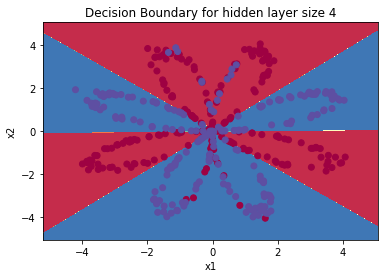

In [17]:
# Prediction
Y_pred_nn = predict(params, X)

# Print accuracy
print ('Accuracy of neural network: %d' % float((np.dot(Y, Y_pred_nn.T) + np.dot(1 - Y,1 - Y_pred_nn.T))/float(Y.size)*100) + '%')

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(params, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

- Tuning hidden layer size

Accuracy for 1 hidden units: 67.5%
Accuracy for 2 hidden units: 67.25%
Accuracy for 3 hidden units: 90.75%
Accuracy for 4 hidden units: 90.5%
Accuracy for 5 hidden units: 91.25%
Accuracy for 20 hidden units: 90.5%
Accuracy for 50 hidden units: 90.75%


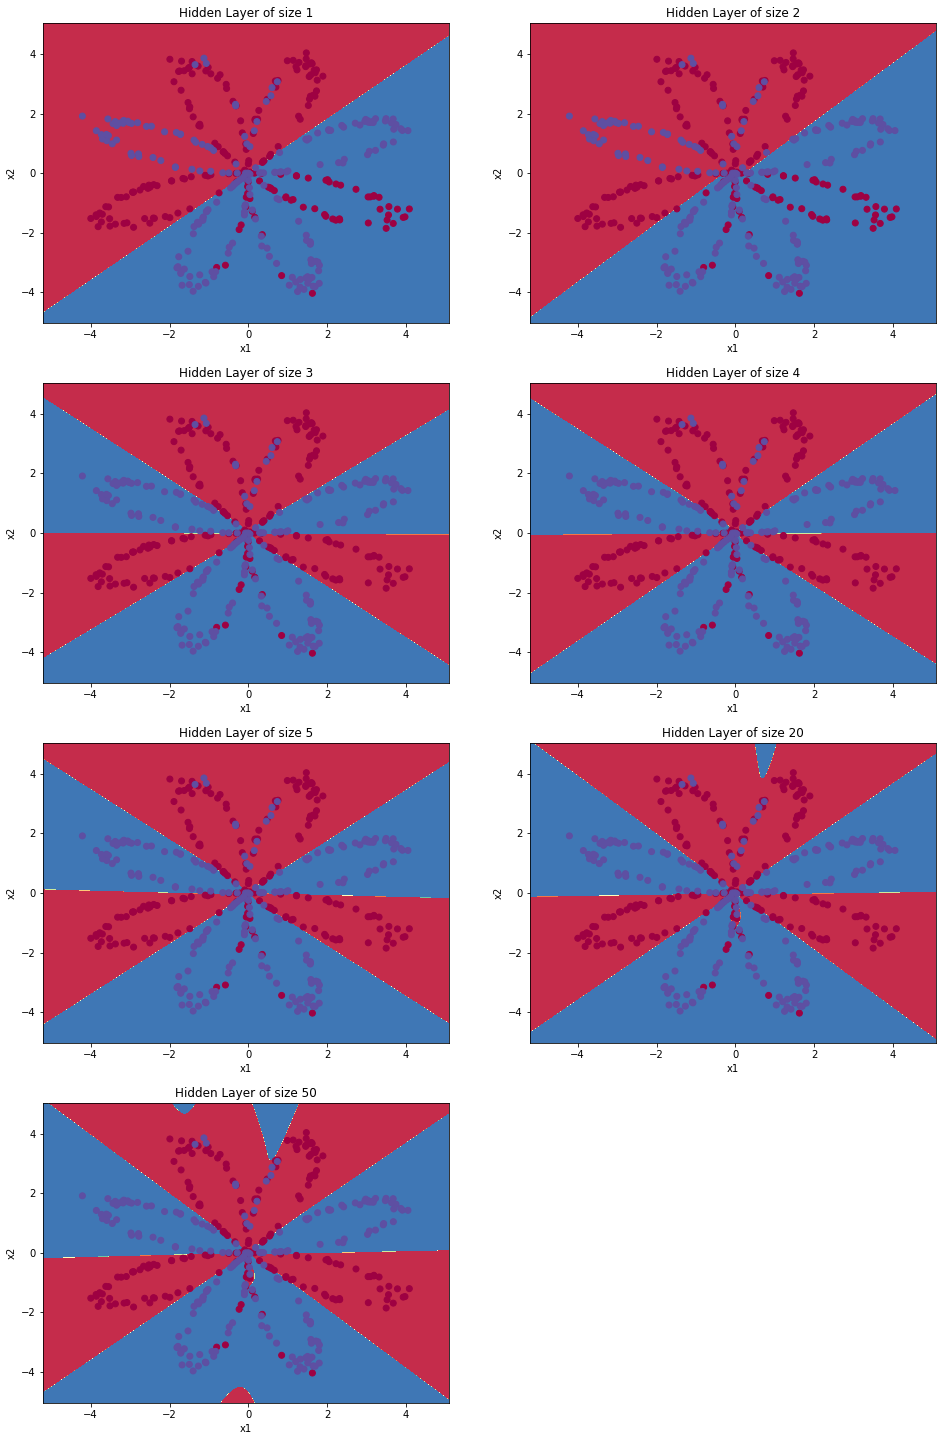

In [18]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    params = nn_model(X, Y, n_h, epochs = 5000)
    plot_decision_boundary(lambda x: predict(params, x.T), X, Y)
    Y_pred = predict(params, X)
    acc = float((np.dot(Y,Y_pred.T) + np.dot(1 - Y,1 - Y_pred.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {}%".format(n_h, acc))